# Project 3: Regression

Load all the packages you are going to use.

**Data manipulation and Visualizations**

In [1]:
pip install movecolumn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import movecolumn as mc
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import set_config

# to visualize the column transformer and pipeline
set_config(display='diagram')

**Feature engineering -- Hyperparameter tunning**

In [3]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

**Modeling**

In [4]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

**Metrics**

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score, mean_squared_log_error

**Cross Validation**

In [6]:
from sklearn.model_selection import cross_validate, cross_val_score

# 1. Define project goal

The goal for this week’s project is to build and train a regression model on the Capital Bike Share (Washington, D.C.) Kaggle data set, in order to predict demand for bicycle rentals at any given hour, based on time and weather, e.g.:

“Given the forecasted weather conditions, how many bicycles can we expect to be rented out (city-wide) this Saturday at 2pm?”

# 2. Get the data

Download the Capital Bike Share Dataset from Kaggle and explore the data in pandas.

You are provided hourly rental data spanning two years. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Read the file train.csv into Python and print a few rows.

In [7]:
df = pd.read_csv("train.csv", index_col = 0, parse_dates = True)

In [8]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [9]:
df.shape

(10886, 11)

In [10]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [11]:
df.index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-19 14:00:00', '2012-12-19 15:00:00',
               '2012-12-19 16:00:00', '2012-12-19 17:00:00',
               '2012-12-19 18:00:00', '2012-12-19 19:00:00',
               '2012-12-19 20:00:00', '2012-12-19 21:00:00',
               '2012-12-19 22:00:00', '2012-12-19 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=10886, freq=None)

Chech for missing values in the train datasets.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


There are no missing values on the dataset.

**Data Dictionary**

**datetime** - hourly date + timestamp  

**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

**holiday** - whether the day is considered a holiday

**workingday** - whether the day is neither a weekend nor holiday

**weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
              2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
              3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
              4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

**temp** - temperature in Celsius

**atemp** - "feels like" temperature in Celsius

**humidity** - relative humidity

**windspeed** - wind speed

**casual** - number of non-registered user rentals initiated

**registered** - number of registered user rentals initiated

**count** - number of total rentals

## Create time-related features

Extract day information.

In [13]:
df["weekday"] = df.index.weekday

Extract hour information.

In [14]:
df["hour"] = df.index.hour


Extract month information.

In [15]:
df["month"] = df.index.month


Extract year information.

In [16]:
df["year"] = df.index.year


In [17]:
df.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weekday,hour,month,year
datetime,,,,,,,,,,,,,,,
2011-01-01,1,0,0,1,9.84,14.395,81,0.0,3,13,16,5,0,1,2011


# 3. Train-test split 

**Define X and y. Drop the "count", "registered" and "casual" columns.**

In [18]:
X = df.drop(["count", "registered", "casual"], axis = 1)

In [19]:
X

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,weekday,hour,month,year
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,5,0,1,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,1,1,2011
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,2,1,2011
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,5,3,1,2011
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,5,4,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,2,19,12,2012
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,2,20,12,2012
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,2,21,12,2012


In [20]:
type(X)

pandas.core.frame.DataFrame

In [21]:
y = df["count"]

In [22]:
y

datetime
2011-01-01 00:00:00     16
2011-01-01 01:00:00     40
2011-01-01 02:00:00     32
2011-01-01 03:00:00     13
2011-01-01 04:00:00      1
                      ... 
2012-12-19 19:00:00    336
2012-12-19 20:00:00    241
2012-12-19 21:00:00    168
2012-12-19 22:00:00    129
2012-12-19 23:00:00     88
Name: count, Length: 10886, dtype: int64

In [23]:
type(y)

pandas.core.series.Series

**Split.**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 12), (2178, 12), (8708,), (2178,))

In [26]:
X_train, X_test

(                     season  holiday  workingday  weather   temp   atemp  \
 datetime                                                                   
 2011-07-06 05:00:00       3        0           1        1  27.88  31.820   
 2012-08-04 16:00:00       3        0           0        1  36.90  40.910   
 2012-07-11 15:00:00       3        0           1        1  32.80  35.605   
 2011-04-10 04:00:00       2        0           0        2  14.76  18.180   
 2011-11-19 10:00:00       4        0           0        1  13.12  15.150   
 ...                     ...      ...         ...      ...    ...     ...   
 2012-01-14 02:00:00       1        0           0        1   6.56   8.335   
 2011-12-10 09:00:00       4        0           0        1  11.48  12.880   
 2011-12-18 16:00:00       4        0           0        1  11.48  13.635   
 2011-02-19 07:00:00       1        0           0        1  15.58  19.695   
 2012-05-02 07:00:00       2        0           1        2  22.14  25.760   

In [27]:
y_train, y_test

(datetime
 2011-07-06 05:00:00     35
 2012-08-04 16:00:00    450
 2012-07-11 15:00:00    276
 2011-04-10 04:00:00      5
 2011-11-19 10:00:00    200
                       ... 
 2012-01-14 02:00:00     38
 2011-12-10 09:00:00    149
 2011-12-18 16:00:00    234
 2011-02-19 07:00:00     22
 2012-05-02 07:00:00    358
 Name: count, Length: 8708, dtype: int64,
 datetime
 2011-07-19 11:00:00    127
 2012-01-16 06:00:00     13
 2011-12-11 18:00:00    163
 2012-08-15 10:00:00    233
 2012-06-15 23:00:00    222
                       ... 
 2011-05-08 17:00:00    351
 2012-01-17 04:00:00      2
 2012-11-04 14:00:00    509
 2012-01-01 05:00:00      5
 2012-05-15 13:00:00    239
 Name: count, Length: 2178, dtype: int64)

# 4. EDA

Questions for data exploration:

   Which factors contribute most to the number of bicycles being checked out over the course of a given day?
   
   How much of an impact does weather have on demand?

   How does the behavior of casual users differ from subscribers?

The value in the count column is the one you need to predict. Beware that combining the columns casual and registerd results in the column count. Therefore you should exclude those columns from your model!


Recunstruct the train dataset to continue with its exploration.

In [28]:
df_train = pd.concat([X_train, y_train], axis = 1)

In [29]:
df_train.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,weekday,hour,month,year,count
datetime,,,,,,,,,,,,,
2011-07-06 05:00:00,3,0,1,1,27.88,31.82,83,6.0032,2,5,7,2011,35


Move "count" to the first column. 

In [30]:
mc.MoveTo1(df_train, "count")

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,weekday,hour,month,year
datetime,,,,,,,,,,,,,
2011-07-06 05:00:00,35,3,0,1,1,27.88,31.820,83,6.0032,2,5,7,2011
2012-08-04 16:00:00,450,3,0,0,1,36.90,40.910,39,19.9995,5,16,8,2012
2012-07-11 15:00:00,276,3,0,1,1,32.80,35.605,41,16.9979,2,15,7,2012
2011-04-10 04:00:00,5,2,0,0,2,14.76,18.180,93,7.0015,6,4,4,2011
2011-11-19 10:00:00,200,4,0,0,1,13.12,15.150,45,16.9979,5,10,11,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-14 02:00:00,38,1,0,0,1,6.56,8.335,47,11.0014,5,2,1,2012
2011-12-10 09:00:00,149,4,0,0,1,11.48,12.880,61,19.0012,5,9,12,2011
2011-12-18 16:00:00,234,4,0,0,1,11.48,13.635,48,16.9979,6,16,12,2011


Alternatively, run the following code.

In [31]:
#first_column = df.pop("count")
#df.insert(0, "count", first_column)
#df.head(1)

Now move "holiday", "workingday" and "season" towards the end of the table, using movecolumn package.

In [32]:
mc.MoveToLast(df_train, "holiday")

,count,season,workingday,weather,temp,atemp,humidity,windspeed,weekday,hour,month,year,holiday
datetime,,,,,,,,,,,,,
2011-07-06 05:00:00,35,3,1,1,27.88,31.820,83,6.0032,2,5,7,2011,0
2012-08-04 16:00:00,450,3,0,1,36.90,40.910,39,19.9995,5,16,8,2012,0
2012-07-11 15:00:00,276,3,1,1,32.80,35.605,41,16.9979,2,15,7,2012,0
2011-04-10 04:00:00,5,2,0,2,14.76,18.180,93,7.0015,6,4,4,2011,0
2011-11-19 10:00:00,200,4,0,1,13.12,15.150,45,16.9979,5,10,11,2011,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-14 02:00:00,38,1,0,1,6.56,8.335,47,11.0014,5,2,1,2012,0
2011-12-10 09:00:00,149,4,0,1,11.48,12.880,61,19.0012,5,9,12,2011,0
2011-12-18 16:00:00,234,4,0,1,11.48,13.635,48,16.9979,6,16,12,2011,0


In [33]:
mc.MoveToLast(df_train, "workingday")

,count,season,weather,temp,atemp,humidity,windspeed,weekday,hour,month,year,holiday,workingday
datetime,,,,,,,,,,,,,
2011-07-06 05:00:00,35,3,1,27.88,31.820,83,6.0032,2,5,7,2011,0,1
2012-08-04 16:00:00,450,3,1,36.90,40.910,39,19.9995,5,16,8,2012,0,0
2012-07-11 15:00:00,276,3,1,32.80,35.605,41,16.9979,2,15,7,2012,0,1
2011-04-10 04:00:00,5,2,2,14.76,18.180,93,7.0015,6,4,4,2011,0,0
2011-11-19 10:00:00,200,4,1,13.12,15.150,45,16.9979,5,10,11,2011,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-14 02:00:00,38,1,1,6.56,8.335,47,11.0014,5,2,1,2012,0,0
2011-12-10 09:00:00,149,4,1,11.48,12.880,61,19.0012,5,9,12,2011,0,0
2011-12-18 16:00:00,234,4,1,11.48,13.635,48,16.9979,6,16,12,2011,0,0


In [34]:
mc.MoveToLast(df_train, "season")

,count,weather,temp,atemp,humidity,windspeed,weekday,hour,month,year,holiday,workingday,season
datetime,,,,,,,,,,,,,
2011-07-06 05:00:00,35,1,27.88,31.820,83,6.0032,2,5,7,2011,0,1,3
2012-08-04 16:00:00,450,1,36.90,40.910,39,19.9995,5,16,8,2012,0,0,3
2012-07-11 15:00:00,276,1,32.80,35.605,41,16.9979,2,15,7,2012,0,1,3
2011-04-10 04:00:00,5,2,14.76,18.180,93,7.0015,6,4,4,2011,0,0,2
2011-11-19 10:00:00,200,1,13.12,15.150,45,16.9979,5,10,11,2011,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-14 02:00:00,38,1,6.56,8.335,47,11.0014,5,2,1,2012,0,0,1
2011-12-10 09:00:00,149,1,11.48,12.880,61,19.0012,5,9,12,2011,0,0,4
2011-12-18 16:00:00,234,1,11.48,13.635,48,16.9979,6,16,12,2011,0,0,4


By all this modifications on the table, the correlation heatmap later would me more comprehensive (at least to me).

In [35]:
df_train.head(1)

,count,weather,temp,atemp,humidity,windspeed,weekday,hour,month,year,holiday,workingday,season
datetime,,,,,,,,,,,,,
2011-07-06 05:00:00,35,1,27.88,31.82,83,6.0032,2,5,7,2011,0,1,3


## Pair and correlation plots. 

Let's try to investigate further the shape of the data.

In [36]:
#sns.pairplot(df_train)

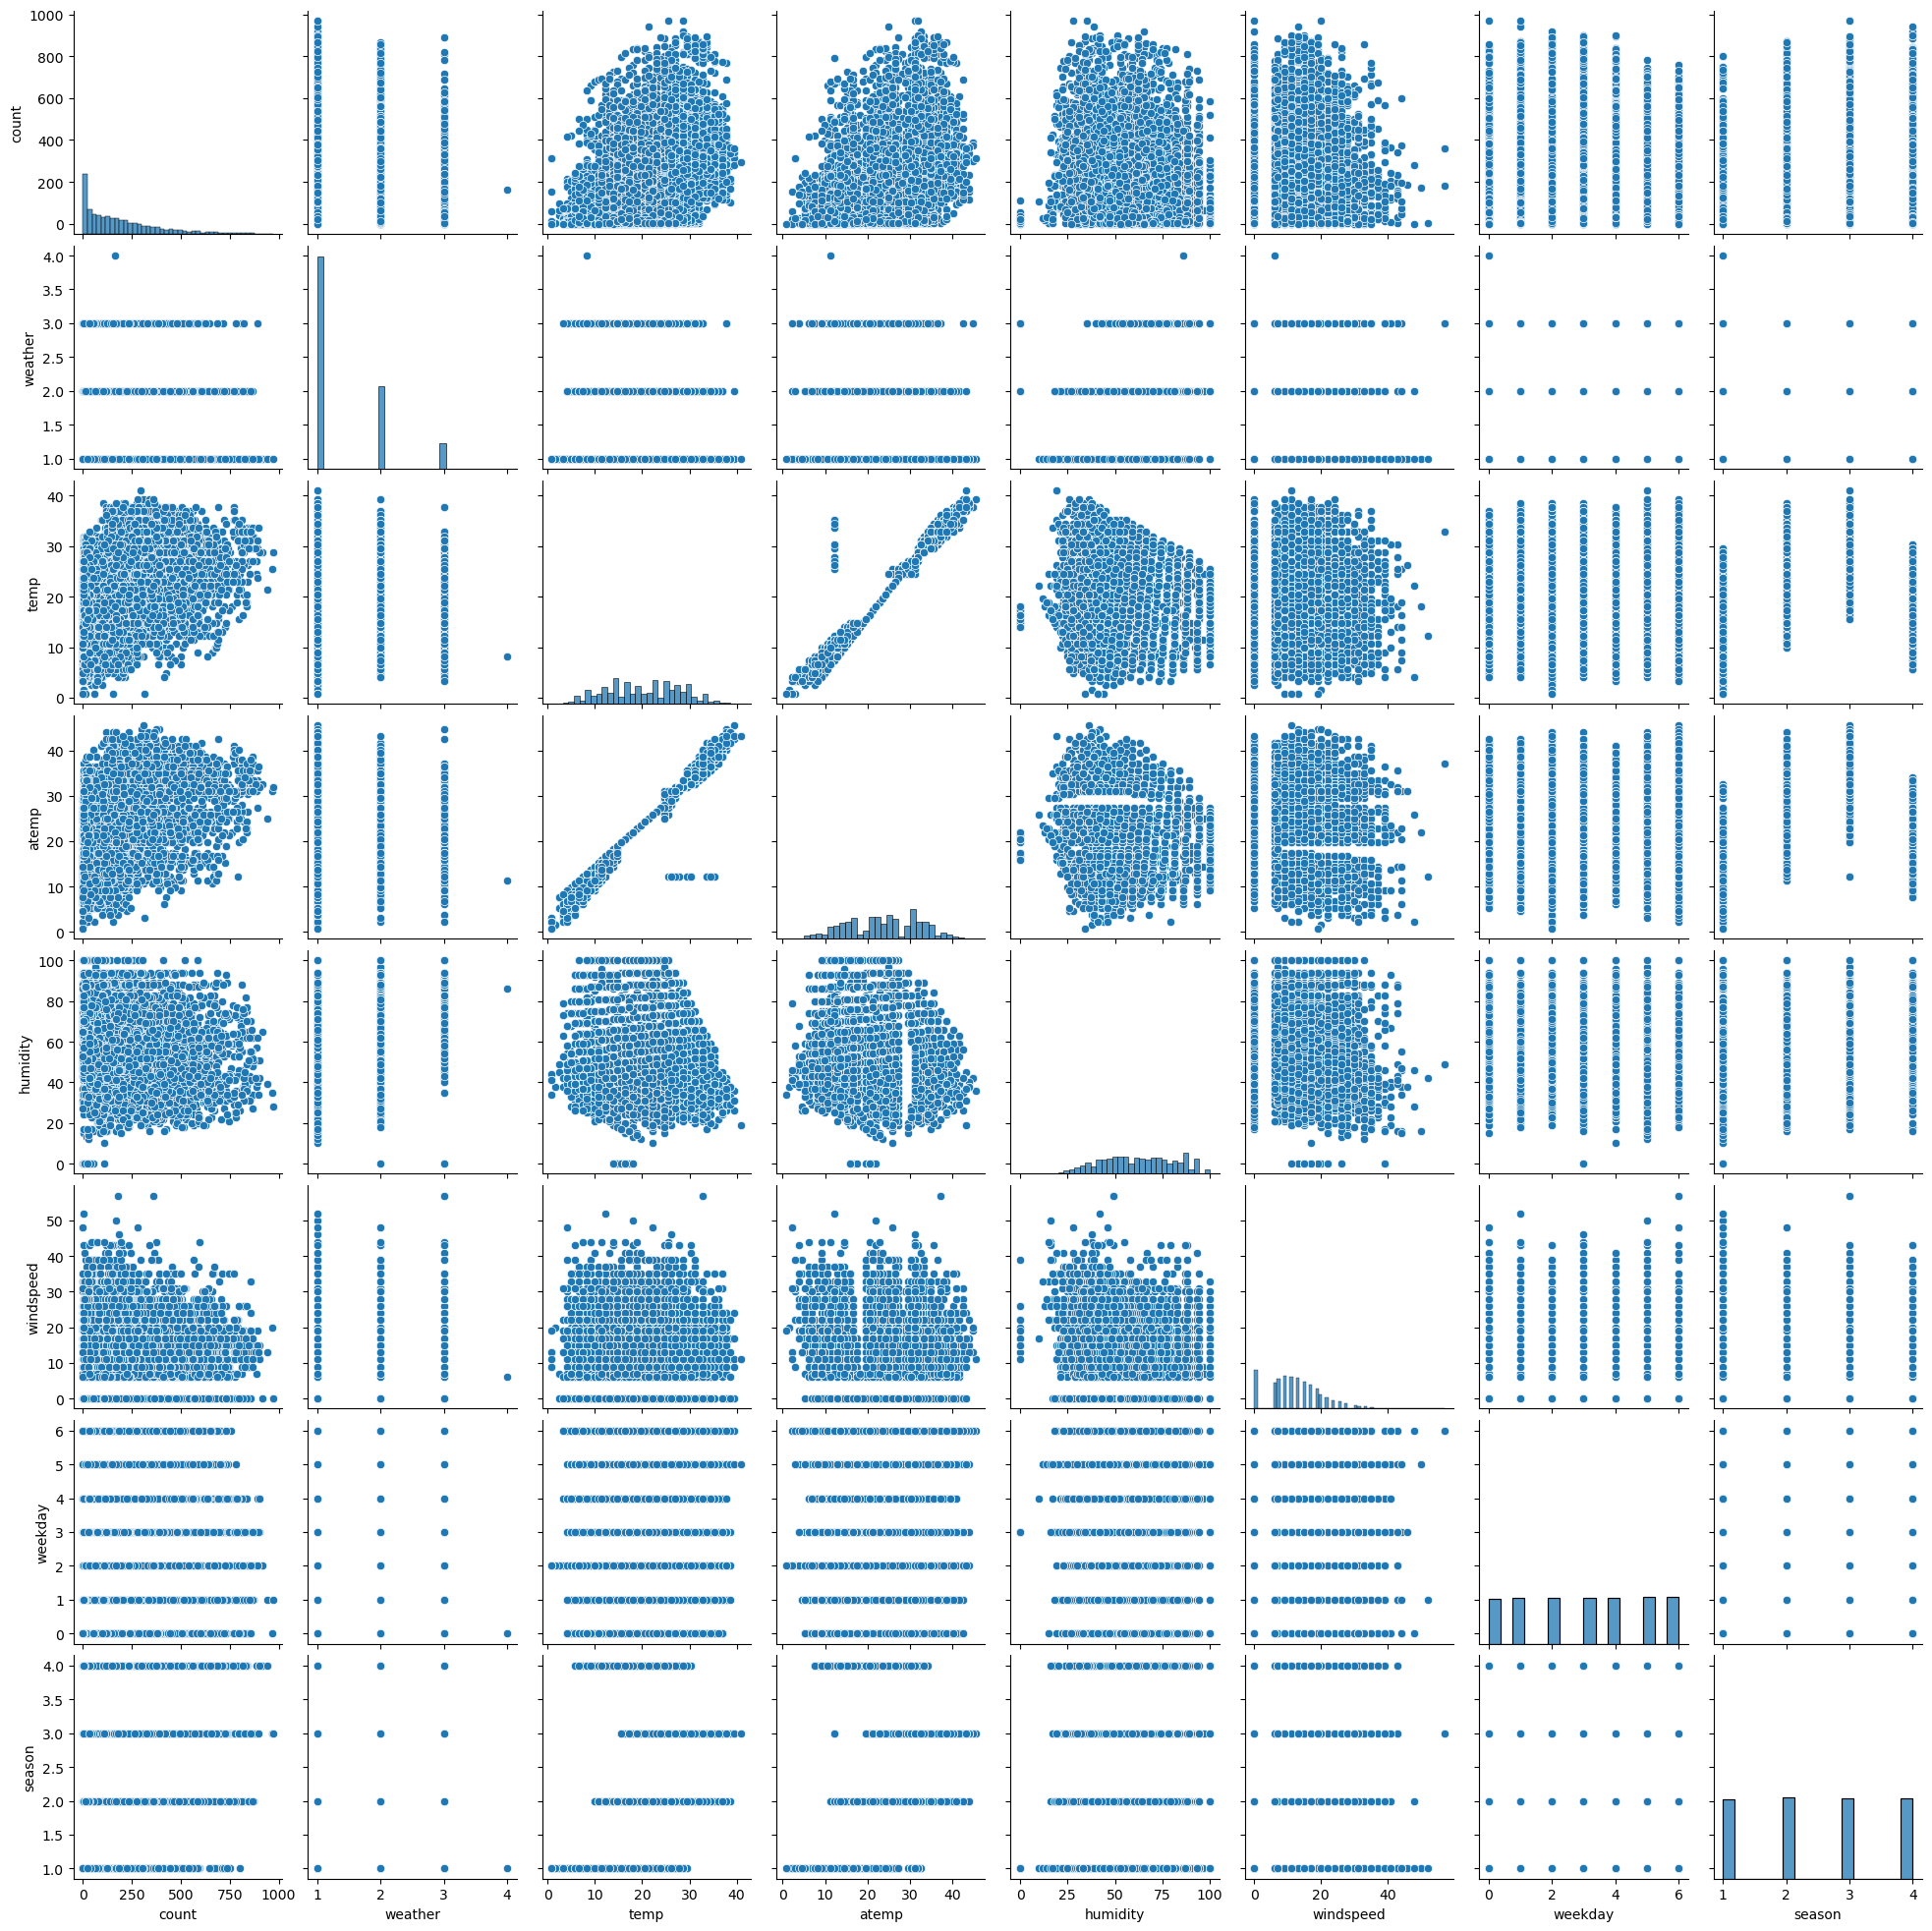

In [37]:
sns.pairplot(df_train.drop(columns = ["holiday", "workingday", "month", "hour", "year"]))

In [38]:
df_train.corr()

,count,weather,temp,atemp,humidity,windspeed,weekday,hour,month,year,holiday,workingday,season
count,1.000000,-0.131122,0.390023,0.385990,-0.318070,0.098819,-0.004942,0.401573,0.164306,0.259431,-0.008153,0.013617,0.161001
weather,-0.131122,1.000000,-0.056508,-0.057588,0.406262,0.011795,-0.045939,-0.025692,0.009483,-0.012075,-0.017063,0.036027,0.006103
temp,0.390023,-0.056508,1.000000,0.984902,-0.069600,-0.015686,-0.037002,0.143478,0.253954,0.060987,-0.005064,0.027855,0.255521
atemp,0.385990,-0.057588,0.984902,1.000000,-0.049581,-0.054451,-0.038418,0.137544,0.259635,0.058341,-0.012046,0.023520,0.260658
humidity,-0.318070,0.406262,-0.069600,-0.049581,1.000000,-0.313266,-0.030498,-0.278153,0.205737,-0.076441,-0.002480,-0.005580,0.192480
windspeed,0.098819,0.011795,-0.015686,-0.054451,-0.313266,1.000000,-0.017841,0.149228,-0.147402,-0.015508,0.015316,0.004963,-0.144962
weekday,-0.004942,-0.045939,-0.037002,-0.038418,-0.030498,-0.017841,1.000000,-0.007633,-0.002879,-0.006922,-0.190036,-0.702569,-0.011498
hour,0.401573,-0.025692,0.143478,0.137544,-0.278153,0.149228,-0.007633,1.000000,-0.013726,-0.004103,0.005212,0.004012,-0.012358
month,0.164306,0.009483,0.253954,0.259635,0.205737,-0.147402,-0.002879,-0.013726,1.000000,-0.005106,-0.000083,0.005824,0.971567
year,0.259431,-0.012075,0.060987,0.058341,-0.076441,-0.015508,-0.006922,-0.004103,-0.005106,1.000000,0.008997,-0.001249,-0.004450


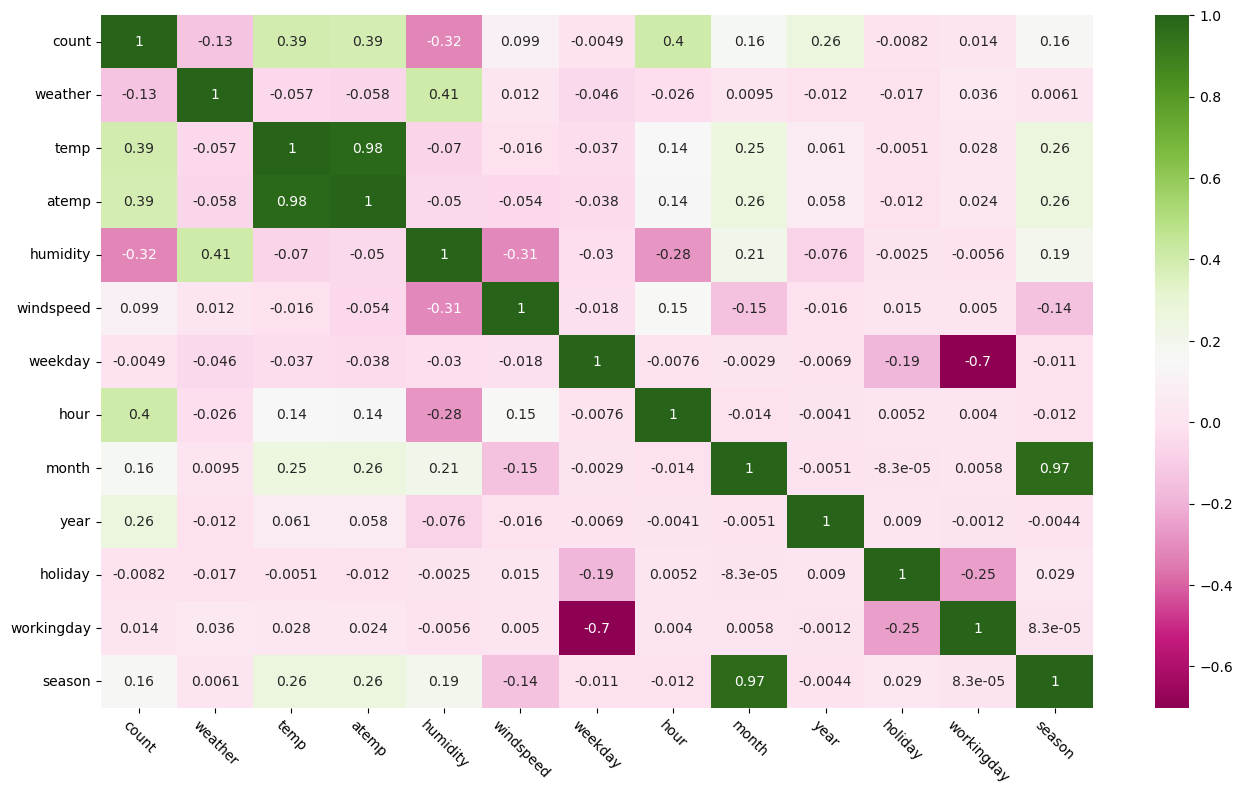

In [39]:
plt.figure(figsize=(16, 9))
hm = sns.heatmap(df_train.corr(), cmap = "PiYG", annot = True)
hm.tick_params(rotation = -45, axis = "x")

The "count"  which are shown to have the strongest correlation with "count" are "hour", "temp", "atemp", "humidity" and "year".

There is strong correlation between "temp" ans "atemp" (0.98), "season" and "month" (0.97) & "weekday" and "workingday" (-0.7). 
**Multicollinearity?**

### Variance Inflation Factor (VIF)

In [40]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data

,feature
0,season
1,holiday
2,workingday
3,weather
4,temp
5,atemp
6,humidity
7,windspeed
8,weekday
9,hour


Calculate VIF for each feature.

In [41]:
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
  
print(vif_data)

       feature         VIF
0       season  109.993396
1      holiday    1.567841
2   workingday    9.020947
3      weather    7.494299
4         temp  275.982709
5        atemp  314.769941
6     humidity   17.331740
7    windspeed    4.113897
8      weekday    9.185530
9         hour    4.237294
10       month   84.133442
11        year   66.882805


## Features related to timestamps.

**Subplots: Holiday Vs count ł Workingday Vs count ł Season Vs count ł Weekday Vs count ł Hour Vs count ł Month Vs count ł Month Vs count Vs year ł Hour Vs count Vs weekday ł Hour Vs count Vs workingday**

In [42]:
#df_train.columns

<AxesSubplot:xlabel='season', ylabel='count'>

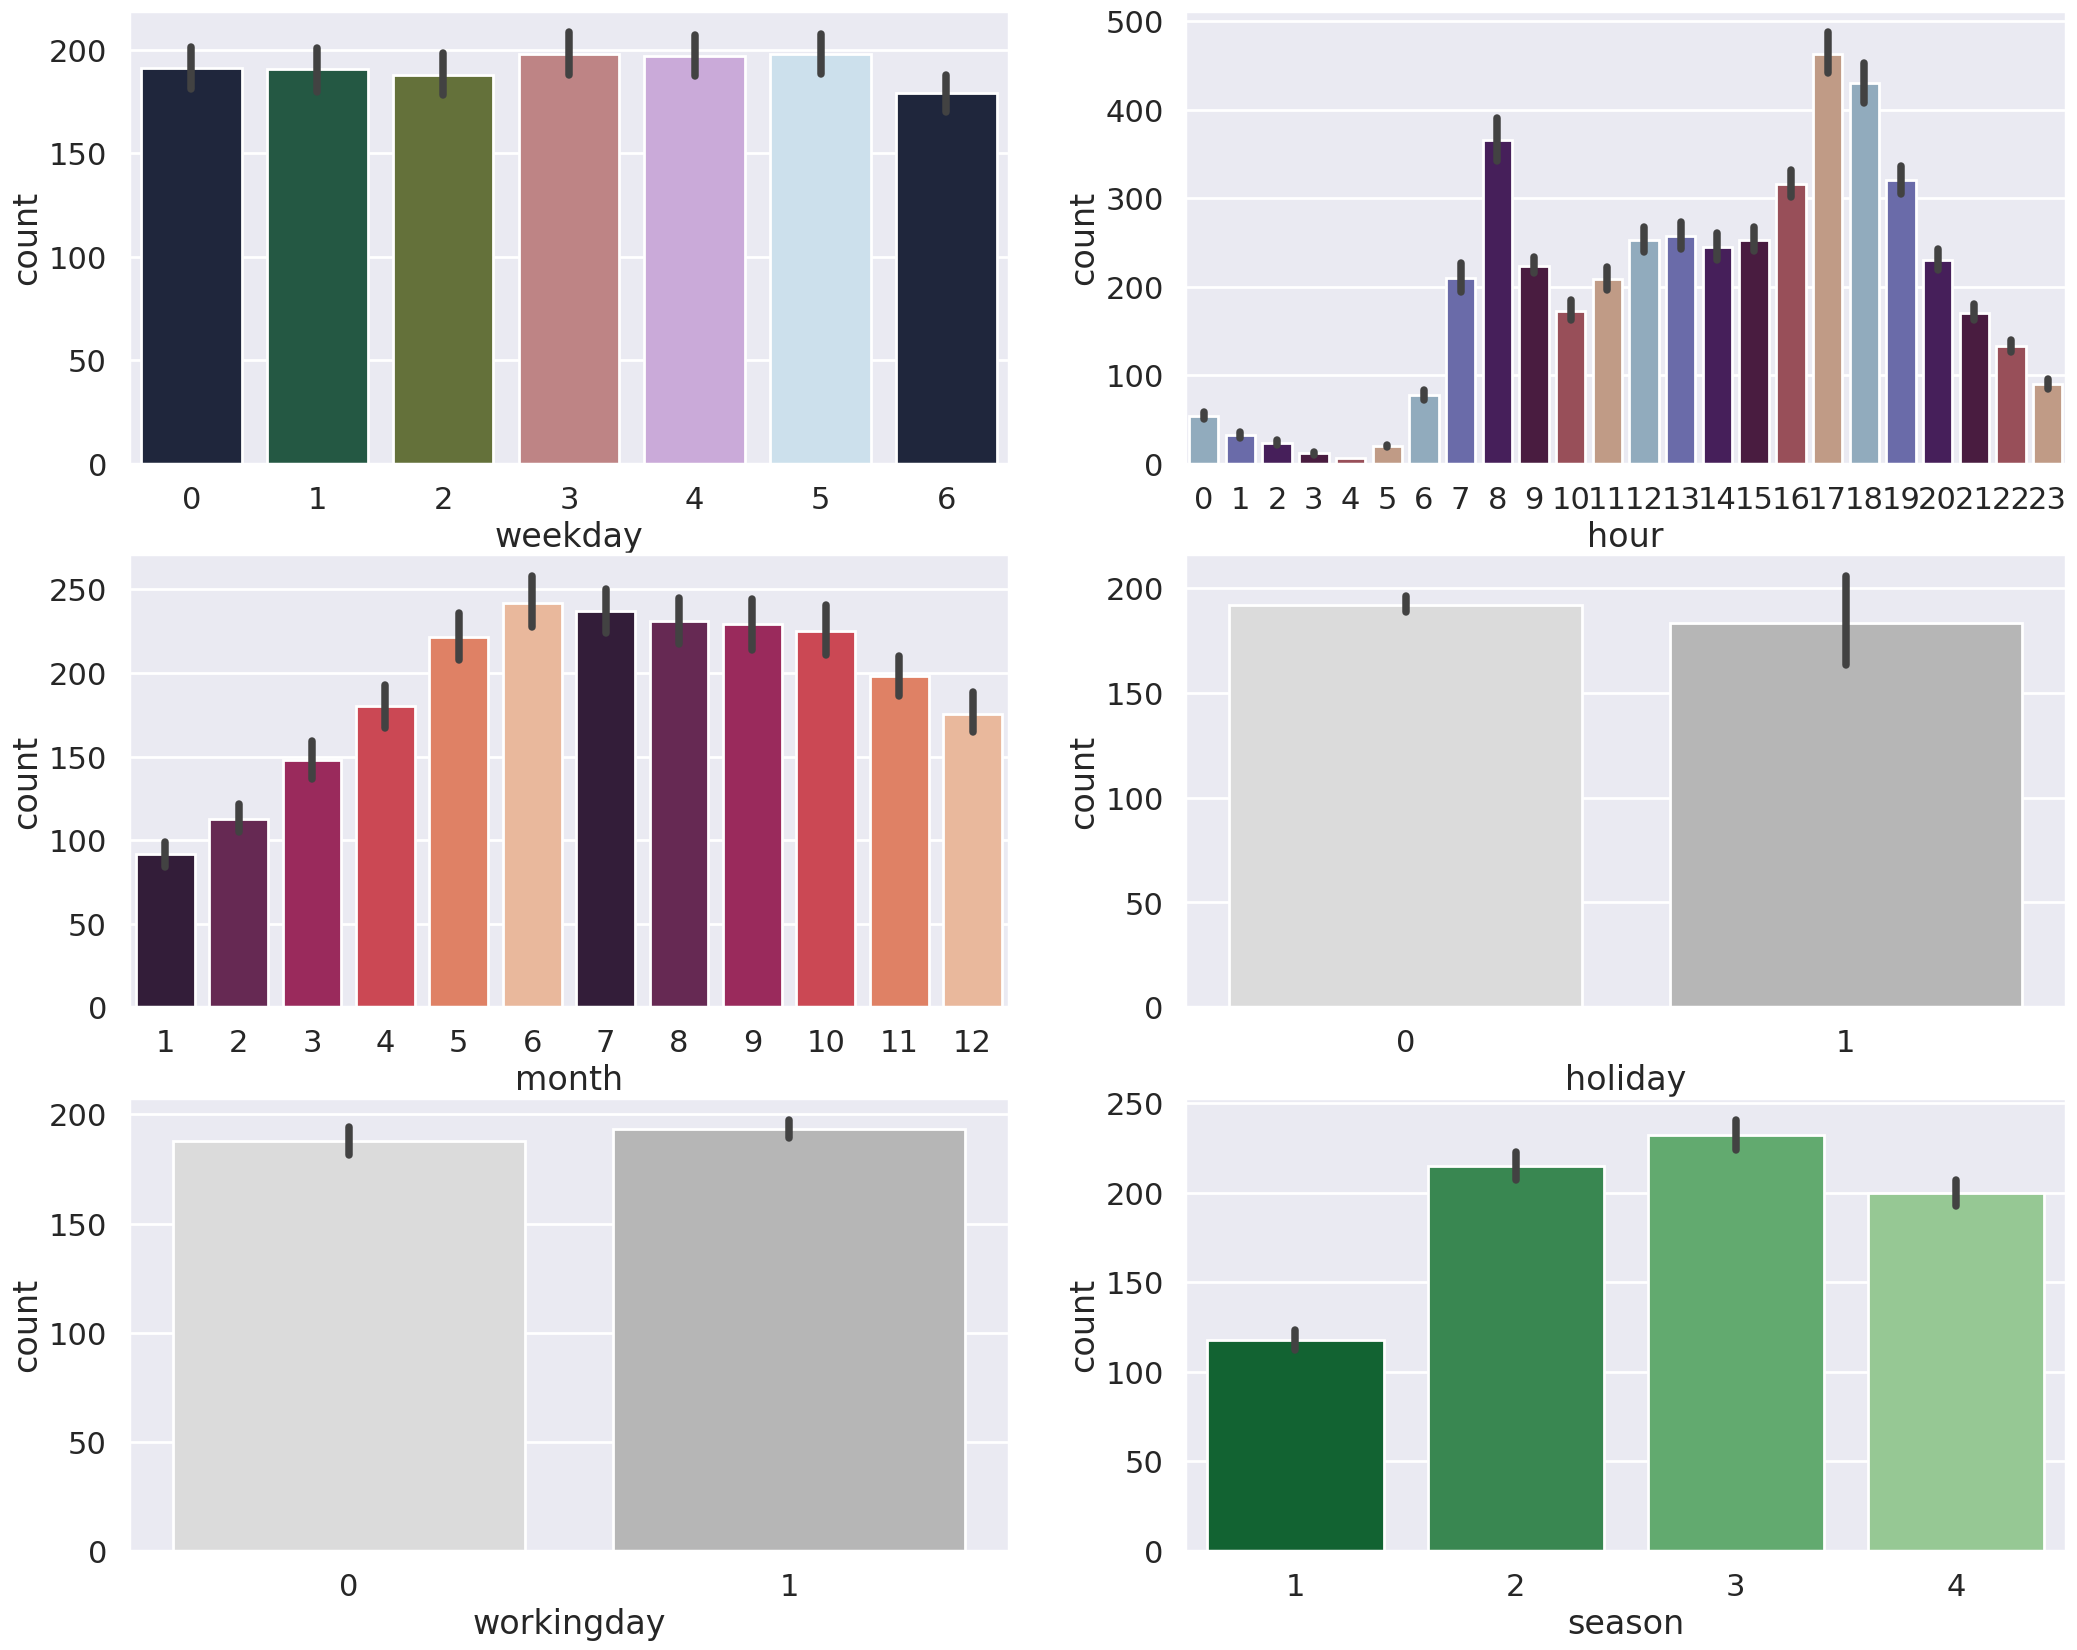

In [43]:
plt.figure(figsize= (25,20))
sns.set_theme("poster")

palette_weekday = sns.color_palette("cubehelix")
palette_h = sns.color_palette("twilight")
palette_m = sns.color_palette("rocket")
palette_hol = sns.color_palette("binary")
palette_work = sns.color_palette("binary")
palette_s = sns.color_palette("Greens_r")

plt.subplot(321)
sns.barplot(data = df_train, x = "weekday", y= "count", palette = palette_weekday)

plt.subplot(322)
sns.barplot(data = df_train, x = "hour", y= "count", palette = palette_h)

plt.subplot(323)
sns.barplot(data = df_train, x = "month", y= "count", palette = palette_m)

plt.subplot(324)
sns.barplot(data = df_train, x = "holiday", y= "count", palette = palette_hol)

plt.subplot(325)
sns.barplot(data = df_train, x = "workingday", y= "count", palette = palette_work)

plt.subplot(326)
sns.barplot(data = df_train, x = "season", y= "count", palette = palette_s)

<AxesSubplot:xlabel='hour', ylabel='count'>

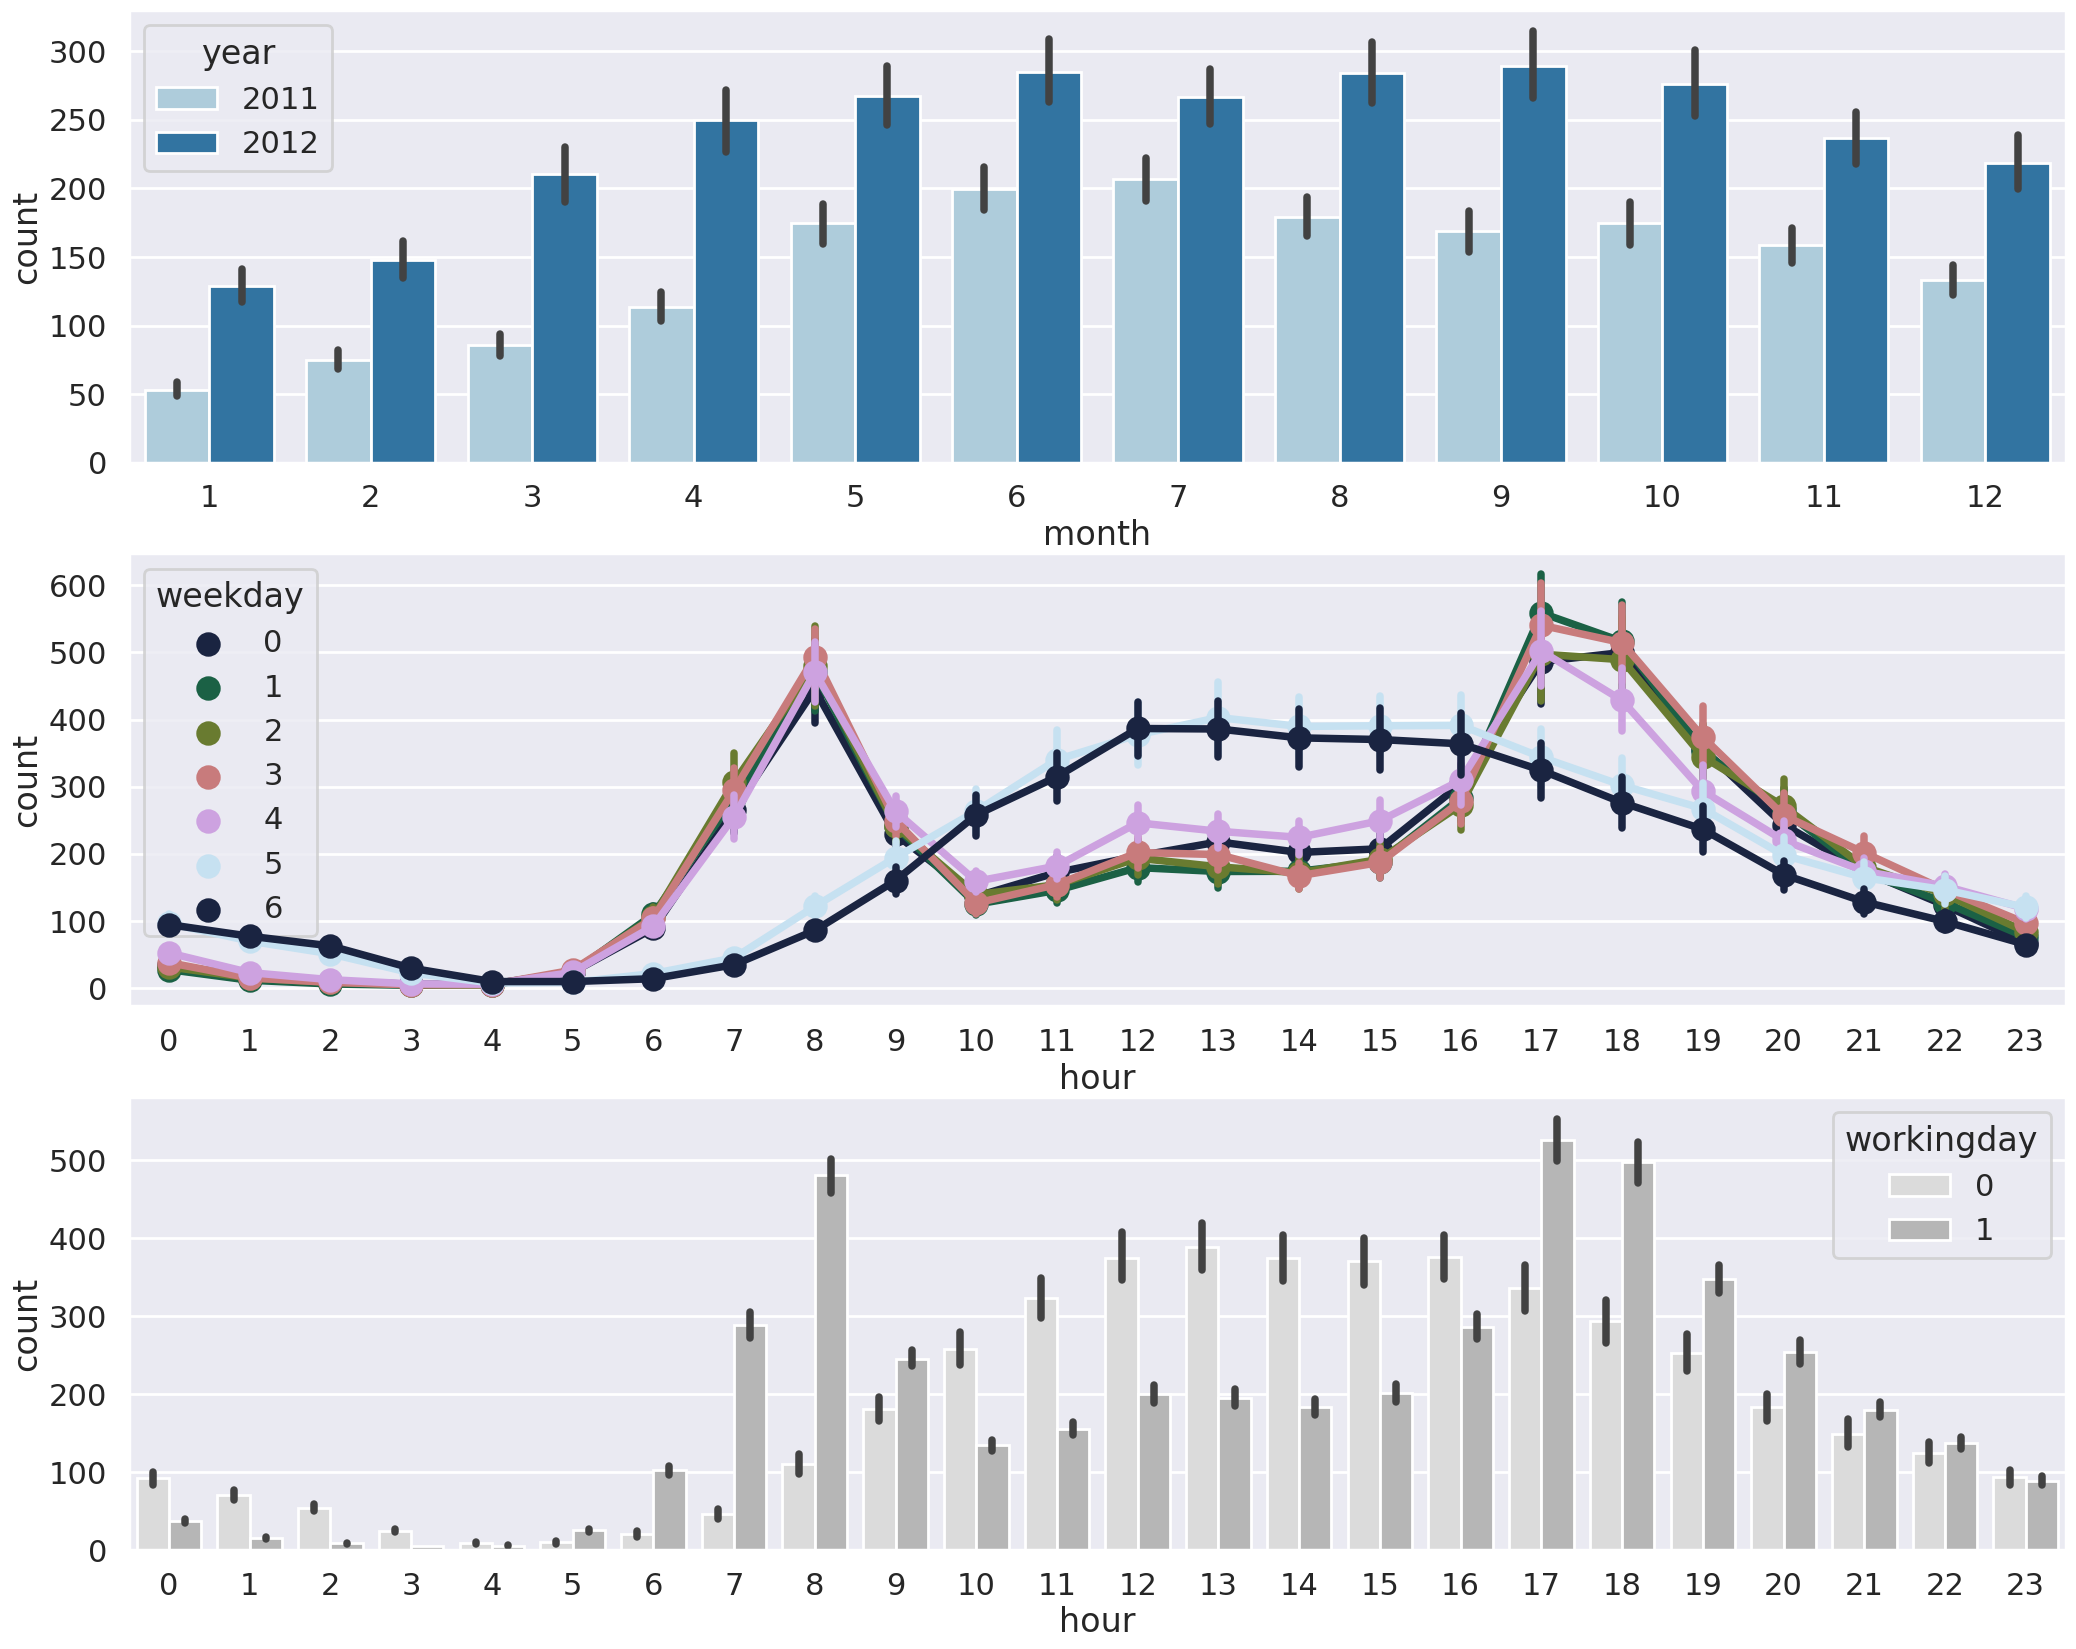

In [44]:
plt.figure(figsize= (25,20))
sns.set_theme("poster")

palette_work = sns.color_palette("binary")
palette_weekday = sns.color_palette("cubehelix")
palette_y = sns.color_palette("Paired")

plt.subplot(311)
sns.barplot(data = df_train, x = "month", y= "count", hue = "year", palette = palette_y)

plt.subplot(312)
sns.pointplot(data = df_train, x = "hour", y = "count", hue = "weekday", palette = palette_weekday, legend='full')

plt.subplot(313)
sns.barplot(data = df_train, x = "hour", y= "count", hue = "workingday", palette = palette_work)

## Features related to the weather.

**Subplots : Temp Vs count ł Atemp Vs count ł Weather Vs count ł Humidity Vs count ł Windspeed Vs count**

<AxesSubplot:xlabel='windspeed', ylabel='count'>

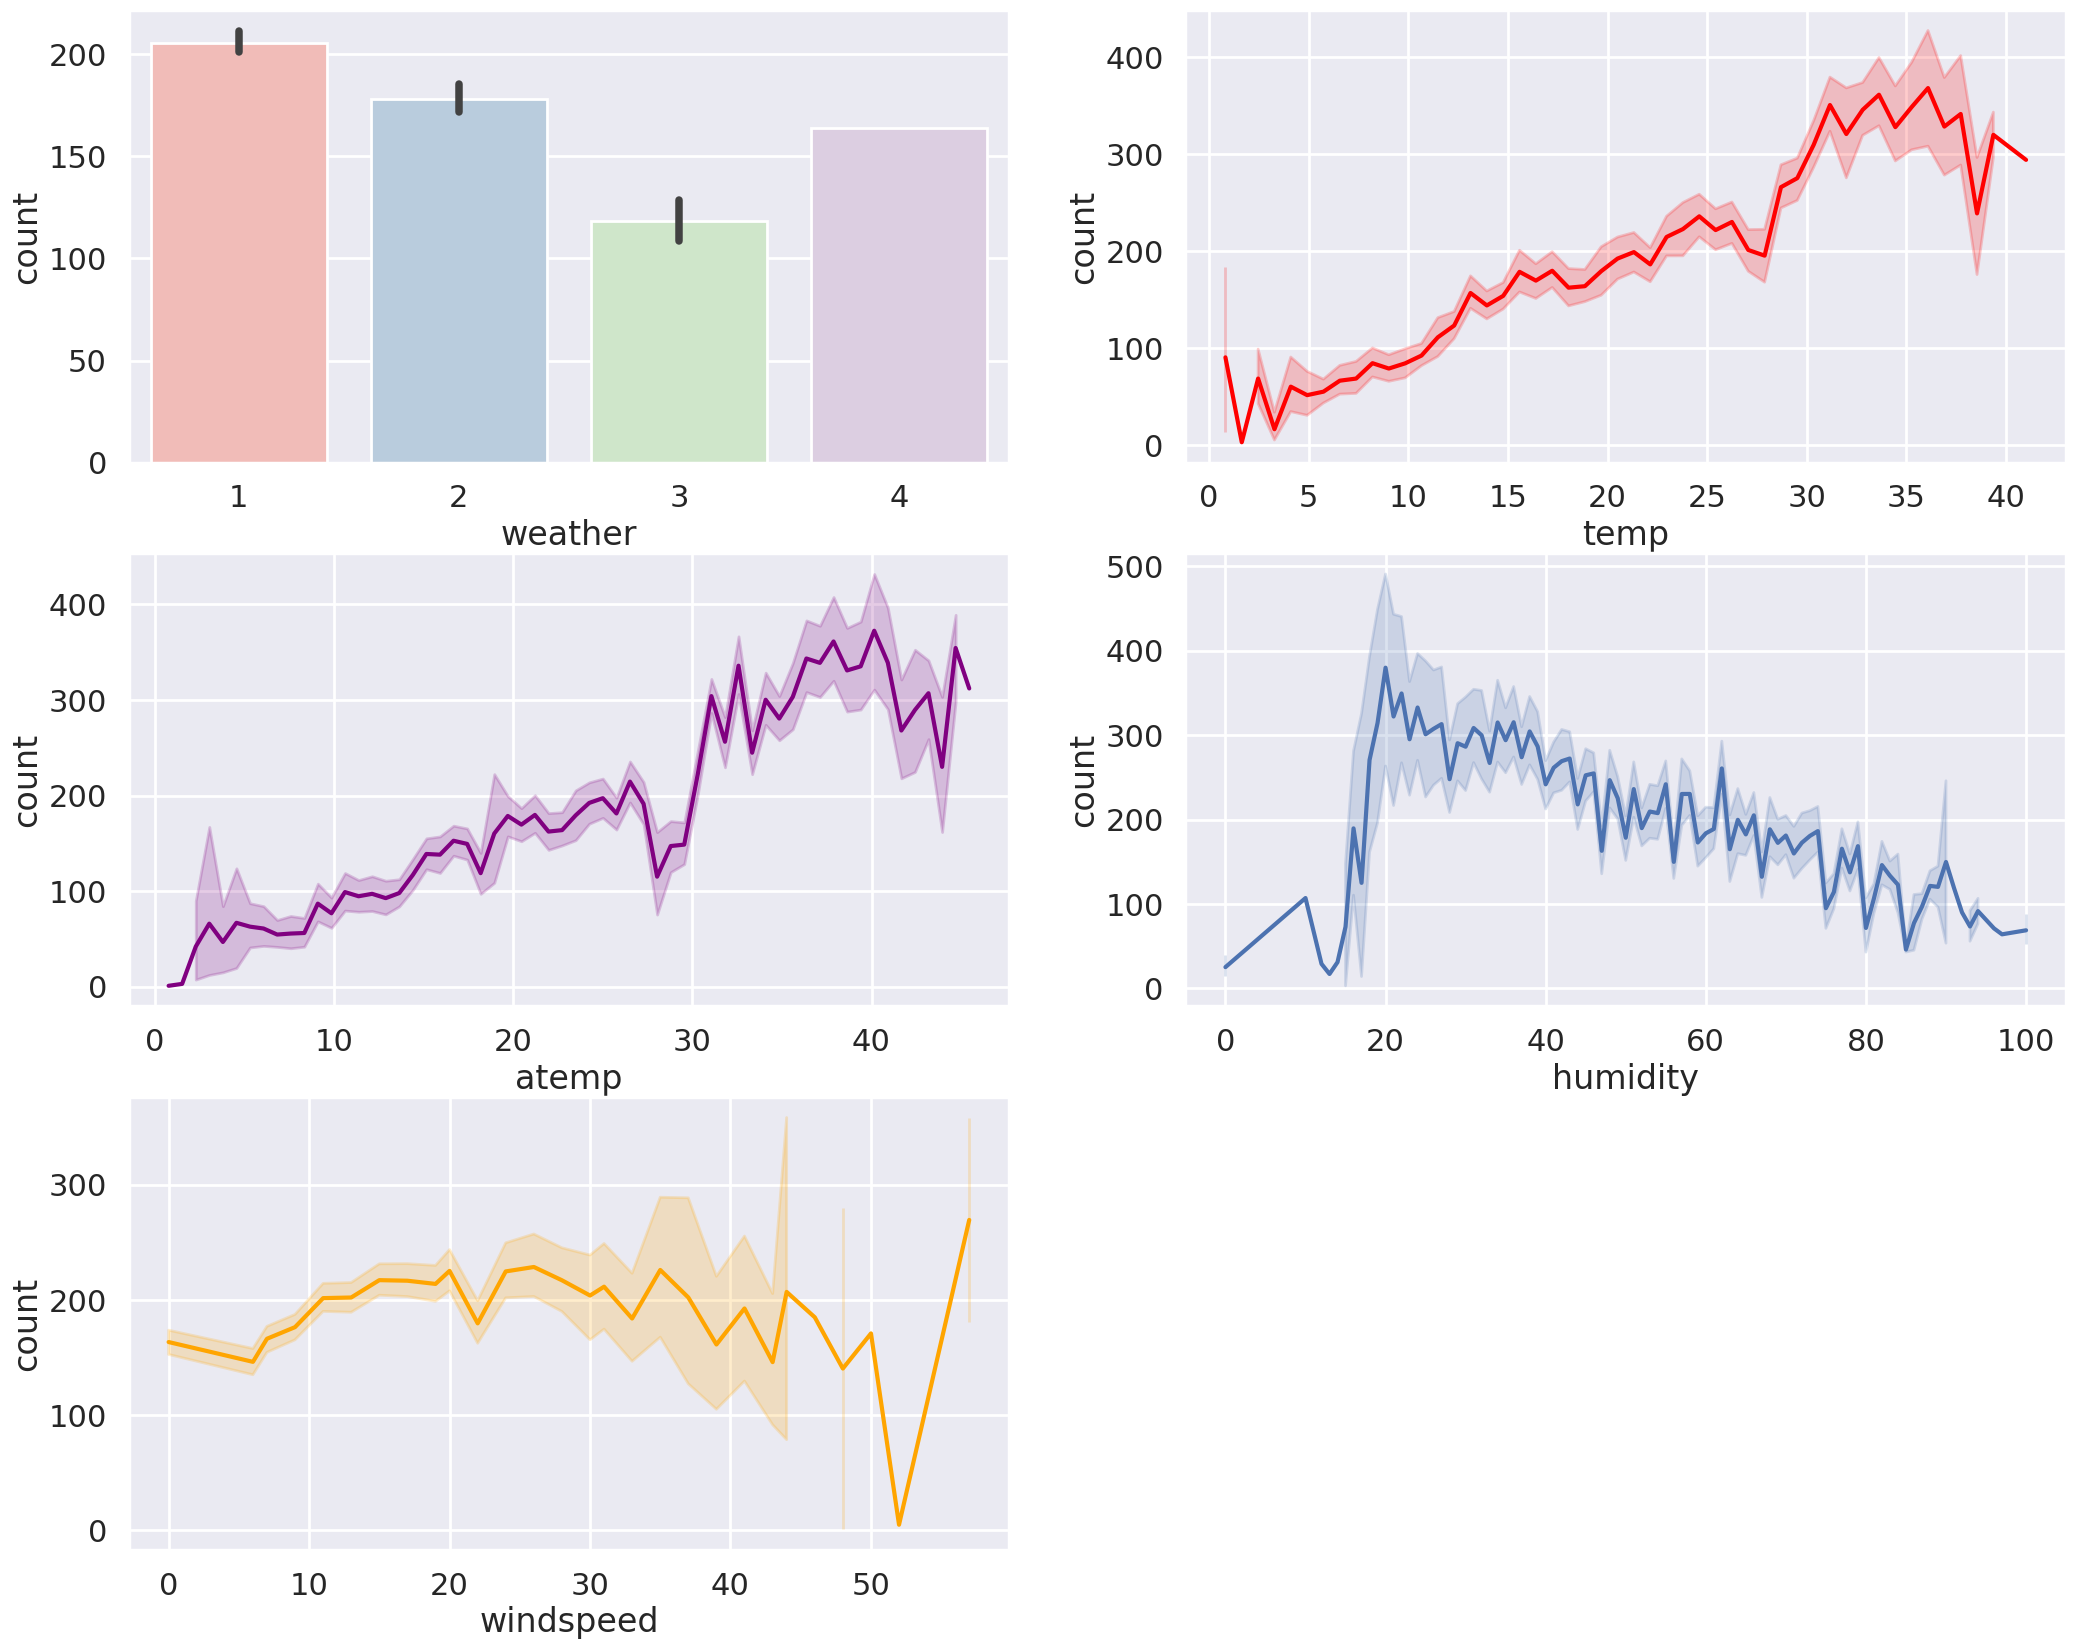

In [45]:
plt.figure(figsize= (25,20))
sns.set_theme("poster")

palette_weather = sns.color_palette("Pastel1")

plt.subplot(321)
sns.barplot(data = df_train, x="weather", y="count", palette = palette_weather)

plt.subplot(322)
sns.lineplot(data = df_train, x="temp", y="count", color = "red")

plt.subplot(323)
sns.lineplot(data = df_train, x="atemp", y="count", color = "purple") 

plt.subplot(324)
sns.lineplot(data = df_train, x="humidity", y="count")

plt.subplot(325)
sns.lineplot(data = df_train, x="windspeed", y="count", color = "orange")


# 5. Feature Engineering

## Decide on the features that are going to be utilized by the model.

### RFE

#### Linear regression

In [46]:
lm = LinearRegression()

In [47]:
rfe_lm = RFE(estimator = lm, verbose = 1, n_features_to_select = 7)

In [48]:
rfe_lm.fit(X_train, y_train)

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.


RFE(estimator=LinearRegression(), n_features_to_select=7, verbose=1)

In [49]:
X_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'weekday', 'hour', 'month', 'year'],
      dtype='object')

In [50]:
rfe_lm.support_

array([ True,  True, False,  True, False,  True, False, False, False,
        True,  True,  True])

In [51]:
features_lm = X_train.columns[rfe_lm.support_]

In [52]:
print(f'Including only the features {features_lm}\nR^2 score  is {round(rfe_lm.score(X_train, y_train),2)}')

Including only the features Index(['season', 'holiday', 'weather', 'atemp', 'hour', 'month', 'year'], dtype='object')
R^2 score  is 0.35


#### RandomForestRegressor

In [53]:
rfr = RandomForestRegressor()

In [54]:
rfe_rfr = RFE(estimator = rfr, verbose = 1, n_features_to_select = 7)

In [55]:
rfe_rfr.fit(X_train, y_train)

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.


RFE(estimator=RandomForestRegressor(), n_features_to_select=7, verbose=1)

In [56]:
X_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'weekday', 'hour', 'month', 'year'],
      dtype='object')

In [57]:
rfe_rfr.support_

array([False, False,  True, False,  True,  True, False, False,  True,
        True,  True,  True])

In [58]:
features_rfr = X_train.columns[rfe_rfr.support_]

In [59]:
print(f'Including only the features {features_rfr}\nR^2 score  is {round(rfe_rfr.score(X_train, y_train),2)}')

Including only the features Index(['workingday', 'temp', 'atemp', 'weekday', 'hour', 'month', 'year'], dtype='object')
R^2 score  is 0.99


**Features' importance**

In [60]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [61]:
feature_importance = rfr.feature_importances_

In [62]:
feature_importance_dict = {"importance": feature_importance, "feature": X_train.columns}

In [63]:
pd.DataFrame(data= feature_importance_dict).sort_values("importance", ascending=False)

,importance,feature
9,0.596836,hour
11,0.084859,year
2,0.059490,workingday
4,0.059136,temp
10,0.048743,month
5,0.047806,atemp
8,0.039654,weekday
6,0.029087,humidity
3,0.014815,weather
7,0.009238,windspeed


### Drop features.

In [64]:
X_train = X_train.drop(["weekday", "weather", "season", "holiday", "temp", "windspeed"], axis = 1)

In [65]:
X_test = X_test.drop(["weekday", "weather", "season", "holiday", "temp", "windspeed"], axis = 1)

In [66]:
X_train.head()

,workingday,atemp,humidity,hour,month,year
datetime,,,,,,
2011-07-06 05:00:00,1,31.820,83,5,7,2011
2012-08-04 16:00:00,0,40.910,39,16,8,2012
2012-07-11 15:00:00,1,35.605,41,15,7,2012
2011-04-10 04:00:00,0,18.180,93,4,4,2011
2011-11-19 10:00:00,0,15.150,45,10,11,2011


In [67]:
X_test.head()

,workingday,atemp,humidity,hour,month,year
datetime,,,,,,
2011-07-19 11:00:00,1,40.150,59,11,7,2011
2012-01-16 06:00:00,0,6.820,54,6,1,2012
2011-12-11 18:00:00,0,11.365,48,18,12,2011
2012-08-15 10:00:00,1,34.090,62,10,8,2012
2012-06-15 23:00:00,1,31.060,53,23,6,2012


## Feature engineering

"workingday", "month" and "year" features need to get an one hot encoding and a drop of the first column to avoid multilinearity.

In [68]:
X_train["workingday"].unique()

array([1, 0])

In [69]:
X_train["month"].unique()

array([ 7,  8,  4, 11,  2, 12, 10,  1,  3,  6,  5,  9])

In [70]:
X_train["year"].unique()

array([2011, 2012])

"atemp", "humidity" and "hour" feature need scaling.

Let's try to do the engineering mentioned above by introducing first general column transformer (keep in mind the EDA for choosing the right parameters) and subsequently pipelines for all the models that I want to train.

Generate a pairplot to decide on the better scaler.

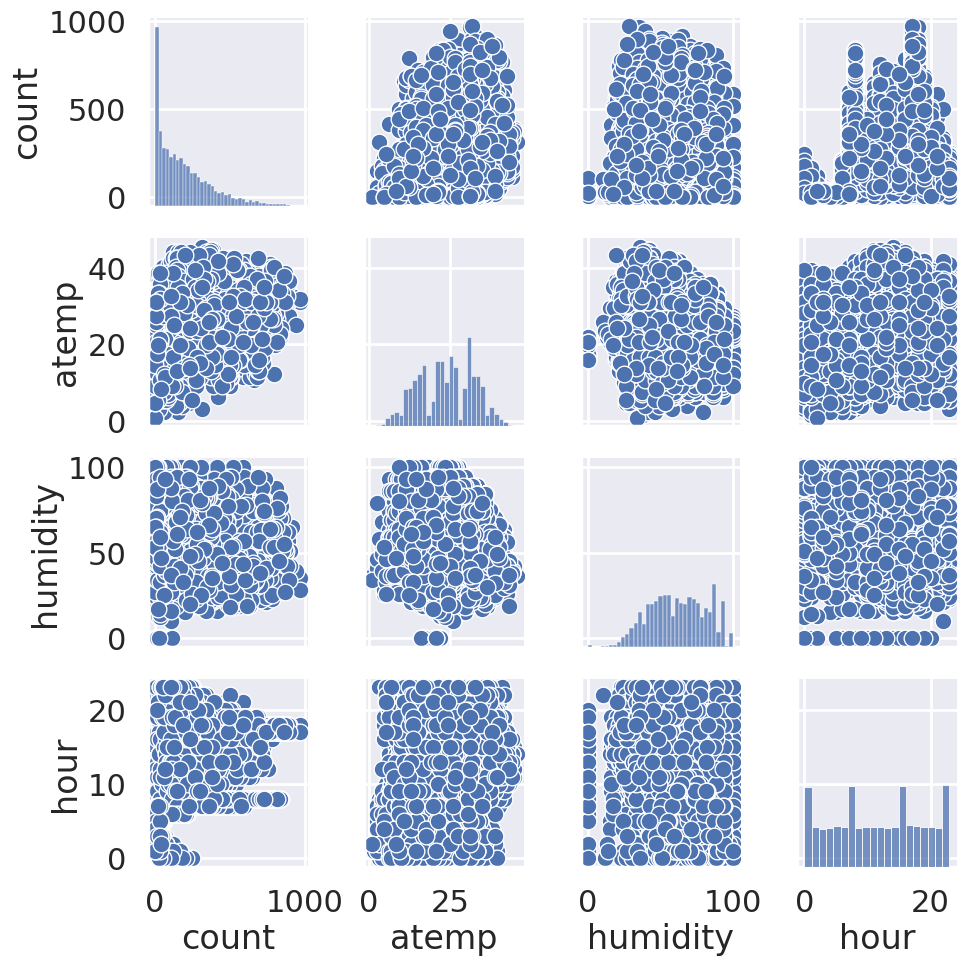

In [71]:
sns.pairplot(df_train.drop(columns = ["holiday", "workingday", "season", "weather", "windspeed", "year", "temp", "month", "weekday"]))

In [72]:
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(drop = "first"), ["workingday", "month", "year"]), 
    ("robust_scaler", RobustScaler(), ["atemp", "humidity"]),
    ("minmax_scaler", MinMaxScaler(), ["hour"])
])

In [73]:
column_transformer

ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop='first'),
                                 ['workingday', 'month', 'year']),
                                ('robust_scaler', RobustScaler(),
                                 ['atemp', 'humidity']),
                                ('minmax_scaler', MinMaxScaler(), ['hour'])])

## Linear regression

**LM pipeline**

In [74]:
lm_pipeline = Pipeline(steps = [
    ("preprocessor", column_transformer),  
    ("regressor", LinearRegression())
])

## Poisson Regression

**PO pipeline**

In [75]:
po_pipeline = Pipeline(steps = [
    ("preprocessor", column_transformer),  
    ("regressor", PoissonRegressor(max_iter= 1000))
])

## Polynomial Regression

**PR pipeline**

In [76]:
poly_pipeline = Pipeline(steps = [
    ("preprocessor", column_transformer), 
    ("poly", PolynomialFeatures(interaction_only = True, include_bias = False)),
    ("regressor", LinearRegression())])  #PCA?

## Lasso Regression

**Lasso pipeline**

In [77]:
lasso_pipeline = Pipeline(steps = [
    ("preprocessor", column_transformer),
    ("regressor", Lasso())
])

## Ridge Regression

**Ridge pipeline**

In [78]:
ridge_pipeline = Pipeline(steps = [
    ("preprocessor", column_transformer),
    ("regressor", Ridge())
])

## ElasticNet Regularization

**ElasticNet pipeline**

In [79]:
en_pipeline = Pipeline(steps = [
    ("preprocessor", column_transformer),
    ("regressor", ElasticNet())
])

## RandomForestRegressor

**RFR pipeline**

In [80]:
rfr_pipeline = Pipeline(steps = [
    ("preprocessor", column_transformer),
    ("regressor", RandomForestRegressor())
])

# 6. Train models

**Fit the Pipelines ONLY using train data.**

## Linear Regression model

Pipeline fitting.

In [81]:
lm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['workingday', 'month',
                                                   'year']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['atemp', 'humidity']),
                                                 ('minmax_scaler',
                                                  MinMaxScaler(), ['hour'])])),
                ('regressor', LinearRegression())])

Check the y_pred.

In [82]:
y_pred_lm = lm_pipeline.predict(X_test)

In [83]:
y_pred_lm

array([230.63532775,  48.17143641, 187.97509682, ..., 318.30153875,
        37.9711084 , 288.78143825])

Look at the scores.

In [84]:
round(lm_pipeline.score(X_train, y_train), 3)

0.397

In [85]:
round(lm_pipeline.score(X_test, y_test), 3)

0.403

Look at the model evaluation metrics.

In [86]:
print('Coefficient of determination: %.3f'
      % r2_score(y_test, y_pred_lm))


print('Mean squared error: %.3f'
      % mean_squared_error(y_test, y_pred_lm))


print('Mean absolute error: %.3f'
      % mean_absolute_error(y_test, y_pred_lm))


Coefficient of determination: 0.403
Mean squared error: 19712.849
Mean absolute error: 104.904


Check the hyperparameters which are available for tunning.

In [87]:
#lm_pipeline.get_params().keys()

## Poisson Regression model

Pipeline fitting.

In [88]:
po_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['workingday', 'month',
                                                   'year']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['atemp', 'humidity']),
                                                 ('minmax_scaler',
                                                  MinMaxScaler(), ['hour'])])),
                ('regressor', PoissonRegressor(max_iter=1000))])

Check the y_pred.

In [89]:
y_pred_po = po_pipeline.predict(X_test)

In [90]:
y_pred_po

array([202.96972022,  72.28438762, 158.41068144, ..., 320.43509723,
        70.60455477, 267.9225866 ])

Look at the scores.

In [91]:
round(po_pipeline.score(X_train, y_train), 3)

0.429

In [92]:
round(po_pipeline.score(X_test, y_test), 3)

0.437

Look at the model evaluation metrics.

In [93]:
print('Coefficient of determination: %.3f'
      % r2_score(y_test, y_pred_po))


print('Mean squared error: %.3f'
      % mean_squared_error(y_test, y_pred_po))


print('Mean absolute error: %.3f'
      % mean_absolute_error(y_test, y_pred_po))


Coefficient of determination: 0.414
Mean squared error: 19328.413
Mean absolute error: 101.802


Check the hyperparameters which are available for tunning.

In [94]:
#po_pipeline.get_params()

## Polynomial Regression model

Pipeline fitting.

In [95]:
poly_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['workingday', 'month',
                                                   'year']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['atemp', 'humidity']),
                                                 ('minmax_scaler',
                                                  MinMaxScaler(), ['hour'])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('regressor', LinearRegression())])

Check the y_pred.

In [96]:
y_pred_poly = poly_pipeline.predict(X_test)

In [97]:
y_pred_poly

array([177.01297782,  26.99341377, 151.98690926, ..., 357.32709614,
        34.88354761, 291.90653377])

Look at the scores.

In [98]:
round(poly_pipeline.score(X_train, y_train), 3)

0.47

In [99]:
round(poly_pipeline.score(X_test, y_test), 3)

0.475

Look at the model evaluation metrics.

In [100]:
print('Coefficient of determination: %.3f'
      % r2_score(y_test, y_pred_poly))


print('Mean squared error: %.3f'
      % mean_squared_error(y_test, y_pred_poly))


print('Mean absolute error: %.3f'
      % mean_absolute_error(y_test, y_pred_poly))


Coefficient of determination: 0.475
Mean squared error: 17331.536
Mean absolute error: 95.212


Check the hyperparameters which are available for tunning.

In [101]:
#poly_pipeline.get_params()

## Regularization models

### Lasso

Pipeline fitting.

In [102]:
lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['workingday', 'month',
                                                   'year']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['atemp', 'humidity']),
                                                 ('minmax_scaler',
                                                  MinMaxScaler(), ['hour'])])),
                ('regressor', Lasso())])

Check the y_pred.

In [103]:
y_pred_la = lasso_pipeline.predict(X_test)

In [104]:
y_pred_la

array([244.0682412 ,  66.65958871, 172.31403349, ..., 300.39084313,
        61.06403198, 275.26112843])

Look at the scores.

In [105]:
round(lasso_pipeline.score(X_train, y_train), 3)

0.393

In [106]:
round(lasso_pipeline.score(X_test, y_test), 3)

0.399

Look at the model evaluation metrics.

In [107]:
print('Coefficient of determination: %.3f'
      % r2_score(y_test, y_pred_la))


print('Mean squared error: %.3f'
      % mean_squared_error(y_test, y_pred_la))


print('Mean absolute error: %.3f'
      % mean_absolute_error(y_test, y_pred_la))


Coefficient of determination: 0.399
Mean squared error: 19831.768
Mean absolute error: 104.451


Check the hyperparameters which are available for tunning.

In [108]:
#lasso_pipeline.get_params().keys()

### Ridge

Pipeline fitting.

In [109]:
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['workingday', 'month',
                                                   'year']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['atemp', 'humidity']),
                                                 ('minmax_scaler',
                                                  MinMaxScaler(), ['hour'])])),
                ('regressor', Ridge())])

Check the y_pred.

In [110]:
y_pred_rd = ridge_pipeline.predict(X_test)

In [111]:
y_pred_rd

array([230.7917519 ,  48.61182314, 187.67153316, ..., 318.14433051,
        38.59332937, 288.74586964])

Look at the scores.

In [112]:
round(ridge_pipeline.score(X_train, y_train), 3)

0.397

In [113]:
round(ridge_pipeline.score(X_test, y_test), 3)

0.403

Look at the model evaluation metrics.

In [114]:
print('Coefficient of determination: %.3f'
      % r2_score(y_test, y_pred_rd))


print('Mean squared error: %.3f'
      % mean_squared_error(y_test, y_pred_rd))


print('Mean absolute error: %.3f'
      % mean_absolute_error(y_test, y_pred_rd))


Coefficient of determination: 0.403
Mean squared error: 19711.989
Mean absolute error: 104.897


Check the hyperparameters which are available for tunning.

In [115]:
#ridge_pipeline.get_params().keys()

### ElasticNet

Pipeline fitting.

In [116]:
en_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['workingday', 'month',
                                                   'year']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['atemp', 'humidity']),
                                                 ('minmax_scaler',
                                                  MinMaxScaler(), ['hour'])])),
                ('regressor', ElasticNet())])

Check the y_pred.

In [117]:
y_pred_en = en_pipeline.predict(X_test)

In [118]:
y_pred_en

array([230.88203847, 154.5569907 , 164.9253634 , ..., 227.36731985,
       143.53253342, 217.37702368])

Look at the scores.

In [119]:
round(en_pipeline.score(X_train, y_train), 3)

0.226

In [120]:
round(en_pipeline.score(X_test, y_test), 3)

0.231

Look at the model evaluation metrics.

In [121]:
print('Coefficient of determination: %.3f'
      % r2_score(y_test, y_pred_en))


print('Mean squared error: %.3f'
      % mean_squared_error(y_test, y_pred_en))


print('Mean absolute error: %.3f'
      % mean_absolute_error(y_test, y_pred_en))


Coefficient of determination: 0.231
Mean squared error: 25385.053
Mean absolute error: 121.704


Check the hyperparameters which are available for tunning.

In [122]:
#en_pipeline.get_params().keys()

## RandomForestRegressor model

Pipeline fitting.

In [123]:
rfr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['workingday', 'month',
                                                   'year']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['atemp', 'humidity']),
                                                 ('minmax_scaler',
                                                  MinMaxScaler(), ['hour'])])),
                ('regressor', RandomForestRegressor())])

Check the y_pred.

In [124]:
y_pred_f = rfr_pipeline.predict(X_test)

In [125]:
y_pred_f

array([137.9175    ,   4.39      , 157.1       , ..., 465.37      ,
         8.2       , 200.50583333])

Look at the scores.

In [126]:
round(rfr_pipeline.score(X_train, y_train), 3)

0.988

In [127]:
round(rfr_pipeline.score(X_test, y_test), 3)

0.926

Look at the model evaluation metrics.

In [128]:
print('Coefficient of determination: %.3f'
      % r2_score(y_test, y_pred_f))


print('Mean squared error: %.3f'
      % mean_squared_error(y_test, y_pred_f))


print('Mean absolute error: %.3f'
      % mean_absolute_error(y_test, y_pred_f))


Coefficient of determination: 0.926
Mean squared error: 2428.821
Mean absolute error: 30.392


Check the hyperparameters which are available for tunning.

In [129]:
#rfr_pipeline.get_params()

# 7. Hyperparameter tunning

## PR Hyperparameter tunning

In [130]:
poly_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'poly', 'regressor', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__ohe', 'preprocessor__robust_scaler', 'preprocessor__minmax_scaler', 'preprocessor__ohe__categories', 'preprocessor__ohe__drop', 'preprocessor__ohe__dtype', 'preprocessor__ohe__handle_unknown', 'preprocessor__ohe__sparse', 'preprocessor__robust_scaler__copy', 'preprocessor__robust_scaler__quantile_range', 'preprocessor__robust_scaler__unit_variance', 'preprocessor__robust_scaler__with_centering', 'preprocessor__robust_scaler__with_scaling', 'preprocessor__minmax_scaler__clip', 'preprocessor__minmax_scaler__copy', 'preprocessor__minmax_scaler__feature_range', 'poly__degree', 'poly__include_bias', 'poly__interaction_only', 'poly__order', 'regressor__copy_X', 'regressor__fit_interce

Define the hyperparameters' combination.

In [131]:
hyperparams_poly = {
    "poly__degree": [4, 5, 6] 
}

Tunning.

In [132]:
gridsearch_poly = GridSearchCV(poly_pipeline, hyperparams_poly, cv= 3, verbose = 1)

In [133]:
gridsearch_poly.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['workingday',
                                                                          'month',
                                                                          'year']),
                                                                        ('robust_scaler',
                                                                         RobustScaler(),
                                                                         ['atemp',
                                                                          'humidity']),
                                                                        ('minmax_scaler',
                                                                         MinMaxScaler(),
                                                                         ['hour'])])),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('regressor', LinearRegression())]),
             param_grid={'poly__degree': [4, 5, 6]}, verbose=1)

Best model, parameters and score.

In [134]:
gridsearch_poly.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['workingday', 'month',
                                                   'year']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['atemp', 'humidity']),
                                                 ('minmax_scaler',
                                                  MinMaxScaler(), ['hour'])])),
                ('poly',
                 PolynomialFeatures(degree=5, include_bias=False,
                                    interaction_only=True)),
                ('regressor', LinearRegression())])

In [135]:
gridsearch_poly.best_params_

{'poly__degree': 5}

In [136]:
gridsearch_poly.best_score_

0.4658967594804759

Overview of all used hyperparameters tested/models trained.

In [137]:
gridsearch_poly.cv_results_

{'mean_fit_time': array([  3.66935444,  43.93779246, 383.69935886]),
 'std_fit_time': array([0.08732333, 0.93791602, 6.7588873 ]),
 'mean_score_time': array([0.04293211, 0.08694784, 0.20140847]),
 'std_score_time': array([0.0029769 , 0.00040929, 0.00852715]),
 'param_poly__degree': masked_array(data=[4, 5, 6],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'poly__degree': 4}, {'poly__degree': 5}, {'poly__degree': 6}],
 'split0_test_score': array([0.47220379, 0.47662323, 0.47400641]),
 'split1_test_score': array([0.46747249, 0.46841061, 0.4684104 ]),
 'split2_test_score': array([0.45293671, 0.45265644, 0.45292905]),
 'mean_test_score': array([0.46420433, 0.46589676, 0.46511529]),
 'std_test_score': array([0.0081982 , 0.00994456, 0.00891467]),
 'rank_test_score': array([3, 1, 2], dtype=int32)}

In [138]:
pd.DataFrame({"params":gridsearch_poly.cv_results_["params"],
              "mean_fit_time":gridsearch_poly.cv_results_["mean_fit_time"],
              'mean_test_score':gridsearch_poly.cv_results_["mean_test_score"]}).sort_values(by = "mean_test_score", ascending= False)

,params,mean_fit_time,mean_test_score
1,{'poly__degree': 5},43.937792,0.465897
2,{'poly__degree': 6},383.699359,0.465115
0,{'poly__degree': 4},3.669354,0.464204


**Evaluate the best model**

In [139]:
gridsearch_poly.predict(X_test)

array([191.1991001 ,  55.98361157, 120.35625572, ..., 456.7411139 ,
        37.94416299, 239.74687585])

In [140]:
np.array(y_test)

array([127,  13, 163, ..., 509,   5, 239])

In [141]:
gridsearch_poly.score(X_test, y_test)

0.49910410435793584

## RFR Hyperparameter tunning

In [142]:
rfr_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'regressor', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__ohe', 'preprocessor__robust_scaler', 'preprocessor__minmax_scaler', 'preprocessor__ohe__categories', 'preprocessor__ohe__drop', 'preprocessor__ohe__dtype', 'preprocessor__ohe__handle_unknown', 'preprocessor__ohe__sparse', 'preprocessor__robust_scaler__copy', 'preprocessor__robust_scaler__quantile_range', 'preprocessor__robust_scaler__unit_variance', 'preprocessor__robust_scaler__with_centering', 'preprocessor__robust_scaler__with_scaling', 'preprocessor__minmax_scaler__clip', 'preprocessor__minmax_scaler__copy', 'preprocessor__minmax_scaler__feature_range', 'regressor__bootstrap', 'regressor__ccp_alpha', 'regressor__criterion', 'regressor__max_depth', 'regressor__max_features', 'regress

Define the hyperparameters' combination.

In [143]:
hyperparams_rfr = {
    "regressor__max_depth": [3, 9, 15], 
    "regressor__n_estimators": [80, 90, 100, 110]
}

Tunning.

In [144]:
gridsearch_rfr = GridSearchCV(rfr_pipeline, hyperparams_rfr, cv = 3, verbose = 1)

In [145]:
gridsearch_rfr.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['workingday',
                                                                          'month',
                                                                          'year']),
                                                                        ('robust_scaler',
                                                                         RobustScaler(),
                                                                         ['atemp',
                                                                          'humidity']),
                                                                        ('minmax_scaler',
                                                                         MinMaxScaler(),
                                                                         ['hour'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [3, 9, 15],
                         'regressor__n_estimators': [80, 90, 100, 110]},
             verbose=1)

Best model, parameters and score.

In [146]:
gridsearch_rfr.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['workingday', 'month',
                                                   'year']),
                                                 ('robust_scaler',
                                                  RobustScaler(),
                                                  ['atemp', 'humidity']),
                                                 ('minmax_scaler',
                                                  MinMaxScaler(), ['hour'])])),
                ('regressor', RandomForestRegressor(max_depth=15))])

In [147]:
gridsearch_rfr.best_params_

{'regressor__max_depth': 15, 'regressor__n_estimators': 100}

In [148]:
gridsearch_rfr.best_score_

0.917784438815192

Overview of all used hyperparameters tested/models trained.

In [149]:
gridsearch_rfr.cv_results_

{'mean_fit_time': array([0.2796243 , 0.2406528 , 0.25582163, 0.29010137, 0.48520128,
        0.54768221, 0.60645088, 0.66682633, 0.75698932, 0.81925972,
        0.9274501 , 0.99681997]),
 'std_fit_time': array([0.04470095, 0.0078385 , 0.00075648, 0.00659119, 0.00182036,
        0.00163946, 0.00434849, 0.0035005 , 0.01200469, 0.00394301,
        0.020743  , 0.00417033]),
 'mean_score_time': array([0.01589688, 0.01421785, 0.01517725, 0.01616883, 0.02604238,
        0.02878555, 0.03078953, 0.03333743, 0.03855284, 0.04251289,
        0.04735192, 0.0507644 ]),
 'std_score_time': array([0.0014884 , 0.00032443, 0.00019985, 0.00039508, 0.00018787,
        0.00043599, 0.00015043, 0.00086015, 0.00018854, 0.00061187,
        0.00072663, 0.00074851]),
 'param_regressor__max_depth': masked_array(data=[3, 3, 3, 3, 9, 9, 9, 9, 15, 15, 15, 15],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
          

In [150]:
pd.DataFrame({"params":gridsearch_rfr.cv_results_["params"],
              "mean_fit_time":gridsearch_rfr.cv_results_["mean_fit_time"],
              "mean_test_score":gridsearch_rfr.cv_results_["mean_test_score"]}).sort_values(by = "mean_test_score", ascending= False)

,params,mean_fit_time,mean_test_score
10,"{'regressor__max_depth': 15, 'regressor__n_est...",0.927450,0.917784
11,"{'regressor__max_depth': 15, 'regressor__n_est...",0.996820,0.917738
9,"{'regressor__max_depth': 15, 'regressor__n_est...",0.819260,0.917030
8,"{'regressor__max_depth': 15, 'regressor__n_est...",0.756989,0.916704
7,"{'regressor__max_depth': 9, 'regressor__n_esti...",0.666826,0.891313
4,"{'regressor__max_depth': 9, 'regressor__n_esti...",0.485201,0.891251
5,"{'regressor__max_depth': 9, 'regressor__n_esti...",0.547682,0.891166
6,"{'regressor__max_depth': 9, 'regressor__n_esti...",0.606451,0.890092
1,"{'regressor__max_depth': 3, 'regressor__n_esti...",0.240653,0.527149
0,"{'regressor__max_depth': 3, 'regressor__n_esti...",0.279624,0.525309


**(Run the folowing lines if you want to visualize the results.)**

%matplotlib notebook

x_plot = [dict_['regressor__max_depth'] for dict_ in gridsearch_rfr.cv_results_['params']]
y_plot = [dict_['regressor__n_estimators'] for dict_ in gridsearch_rfr.cv_results_['params']]
z_plot = gridsearch_rfr.cv_results_['mean_test_score']

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_plot, y_plot, z_plot, marker='o')

ax.set_xlabel('Depth')
ax.set_ylabel('N_estimators')
ax.set_zlabel('score')

plt.show()

%matplotlib inline

plt.close(fig)

**Evaluate the best model**

In [151]:
gridsearch_rfr.predict(X_test)

array([135.95466034,   4.71869048, 160.35579329, ..., 462.89537193,
         7.49973509, 219.44922736])

In [152]:
np.array(y_test)

array([127,  13, 163, ..., 509,   5, 239])

In [153]:
gridsearch_rfr.score(X_test, y_test)

0.9258049577875541

# 8. Cross validation

## Linear regression model

In [154]:
CV_lm_score = np.mean(cross_val_score(lm_pipeline,X_train,y_train)).round(2)

In [155]:
print(CV_lm_score)

0.39


## Poisson regression model

In [156]:
CV_po_score = np.mean(cross_val_score(po_pipeline,X_train,y_train)).round(2)

In [157]:
print(CV_po_score)

0.43


## Polynomial regression model

In [158]:
CV_poly_score = np.mean(cross_val_score(poly_pipeline,X_train,y_train)).round(2)

In [159]:
print(CV_poly_score)

0.46


Cross Validation score for the best model after HT.

In [160]:
HT_CV_poly_score = np.mean(cross_val_score(gridsearch_poly.best_estimator_, X_train, y_train)).round(2)

In [161]:
print(HT_CV_poly_score)

0.47


## Lasso regression model

In [162]:
CV_la_score = np.mean(cross_val_score(lasso_pipeline,X_train,y_train)).round(2)

In [163]:
print(CV_la_score)

0.39


## Ridge regression model

In [164]:
CV_rd_score = np.mean(cross_val_score(ridge_pipeline,X_train,y_train)).round(2)

In [165]:
print(CV_rd_score)

0.39


## ElasticNet regression model

In [166]:
CV_en_score = np.mean(cross_val_score(en_pipeline,X_train,y_train)).round(2)

In [167]:
print(CV_en_score)

0.22


## RandomForestRegressor model

In [168]:
CV_rfr_score = np.mean(cross_val_score(rfr_pipeline,X_train,y_train)).round(2)

In [169]:
print(CV_rfr_score)

0.92


Cross Validation score for the best model after HT.

In [170]:
HT_CV_rfr_score = np.mean(cross_val_score(gridsearch_rfr.best_estimator_, X_train, y_train)).round(2)

In [171]:
print(HT_CV_rfr_score)

0.92


# 9. Decide on the better fitting model

Define RMSLE score.

In [196]:
def rmsle(y_true, y_pred):
    y_pred[y_pred < 0] = 0
    return mean_squared_log_error(y_true, y_pred)**0.5

## Polynomial Regression

In [173]:
y_pred_gridpoly = gridsearch_poly.best_estimator_.predict(X_test)
#y_pred_gridpoly[y_pred_gridpoly < 0] = 0
#assert all(y_pred_gridpoly >= 0)

In [175]:
rmsle_poly = rmsle(y_test, y_pred_gridpoly)
#mean_squared_log_error(y_test, y_pred_gridpoly)**0.5

In [176]:
print(rmsle_poly)

1.2181219791284468


## RandomForestRegressor

In [177]:
y_pred_gridrfr = gridsearch_rfr.best_estimator_.predict(X_test)

In [178]:
rmsle_rfr = rmsle(y_test, y_pred_gridrfr)

In [179]:
print(rmsle_rfr)

0.37828307365284847


**RandomForestRegressor????**

# 10. How to get the .csv files for Kaggle 

#### Load test dataset of Kaggle.

In [180]:
df_sub = pd.read_csv("test.csv", index_col = 0, parse_dates = True)

In [181]:
df_sub.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [182]:
df_sub.shape

(6493, 8)

Extract day information.

In [183]:
df_sub["weekday"] = df_sub.index.weekday

Extract hour information.

In [184]:
df_sub["hour"] = df_sub.index.hour


Extract month information.

In [185]:
df_sub["month"] = df_sub.index.month


Extract year information.

In [186]:
df_sub["year"] = df_sub.index.year


In [187]:
df_sub.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,weekday,hour,month,year
datetime,,,,,,,,,,,,
2011-01-20,1,0,1,1,10.66,11.365,56,26.0027,3,0,1,2011


#### Drop columns you decided in your model that as not needed.

In [188]:
df_sub.drop(["weekday", "weather", "season", "holiday", "temp", "windspeed"], axis = 1, inplace = True)

In [189]:
df_sub.head()

,workingday,atemp,humidity,hour,month,year
datetime,,,,,,
2011-01-20 00:00:00,1,11.365,56,0,1,2011
2011-01-20 01:00:00,1,13.635,56,1,1,2011
2011-01-20 02:00:00,1,13.635,56,2,1,2011
2011-01-20 03:00:00,1,12.880,56,3,1,2011
2011-01-20 04:00:00,1,12.880,56,4,1,2011


In [190]:
df_sub.isnull().sum()

workingday    0
atemp         0
humidity      0
hour          0
month         0
year          0
dtype: int64

#### Extract the predictions.

In [191]:
y_pred = gridsearch_rfr.best_estimator_.predict(df_sub)

In [192]:
y_pred

array([ 11.60905087,   5.17522982,   4.93386476, ..., 121.047     ,
       110.2375464 ,  79.21033333])

#### Save them to a DataFrame and export them to a .csv file.

In [193]:
predictions = pd.DataFrame({"datetime": df_sub.index, "count": y_pred})

In [194]:
predictions

,datetime,count
0,2011-01-20 00:00:00,11.609051
1,2011-01-20 01:00:00,5.175230
2,2011-01-20 02:00:00,4.933865
3,2011-01-20 03:00:00,3.339407
4,2011-01-20 04:00:00,2.884249
...,...,...
6488,2012-12-31 19:00:00,346.361990
6489,2012-12-31 20:00:00,236.625051
6490,2012-12-31 21:00:00,121.047000
6491,2012-12-31 22:00:00,110.237546


In [195]:
pred_csv = predictions.to_csv("predictions.csv", index = False)